In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from numpy.linalg import norm
from math import sqrt

**Huge diffusion file in a google disk**

In [21]:
def make_df_get_Dt(path, N):
    df = pd.read_csv(path, skiprows=[0, 1, 2])

    with open(path) as f:
        f.readline()
        line = f.readline()

    Dt = float(line.split(':')[-1][:-1])    # шаг по времени для соседних строчек в диффузии

    return df, Dt

**Условие чтобы не было list index out of range для пандаса: предыдущее + step <= количество строк, если поделить пополам количество строчеки взять чуток поменьше, то получится все норм. Это связно с тем, что для подсчета расстояние надо делать row_numb + step, а step - это через сколько строчек по датасету я перепрыгиваю.**


In [25]:
def calculate_all_means(max_step, df, Dt, interval_for_step=10):
    '''
    Возвращает массив из усредненного по всем перемещениям для каждой частицы и затем по всем частиц из перемещений для разных времен перемещения
    и массив отрезков времени для которых как раз получено значение перемещения.
    df: pd.Dataframe
    Dt: расстояние по времени между двумя соседними строчками в датафрейме
    '''

    steps = [step for step in range(1, max_step + 1, interval_for_step)]    # через такое количество строчек я смотрю перемещение-проходясь по циклу я для разных времен перемещения получаю значения
    # print(steps)
    all_means = []
    for step in steps:
        part_dict = {}
        for i in range(N):
            part_dict[i] = np.array([])
        
        for row_numb in steps:
            for p_numb in range(N):
                row = df.iloc[row_numb]
                x = row[str(p_numb) + 'x']
                y = row[str(p_numb) + 'y']
                z = row[str(p_numb) + 'z']
                pos = np.array([x, y, z])

                row_next = df.iloc[row_numb + step]     # берем для той же частицы с шагом step ряд
                x_next = row_next[str(p_numb) + 'x']
                y_next = row_next[str(p_numb) + 'y']
                z_next = row_next[str(p_numb) + 'z']
                pos_next = np.array([x_next, y_next, z_next])
                
                s_square = norm(pos_next - pos) ** 2
                part_dict[p_numb] = np.append(part_dict[p_numb], s_square)

        mean_dict = {}
        for i in range(N):
            mean_dict[i] = part_dict[i].mean()

        total_mean_for_step = np.array(list(mean_dict.values())).mean()

        all_means.append(total_mean_for_step)

    return all_means, Dt * np.array(steps)
    

ceil(max / interval) - количество точек в графике

In [26]:
N = 100
path_best = '../graphs/diff_100p_300k_steps.csv'

In [27]:
df, Dt = make_df_get_Dt(path=path_best, N=N)
all_means, dt_of_steps = calculate_all_means(max_step=2380, df=df, Dt=Dt, interval_for_step=16)

In [31]:
pd.DataFrame(
    {'all_means': all_means, 'dt_of_steps': dt_of_steps}
).to_csv('../graphs/diffusion_ready/100p_300k_ready.csv', index=False)

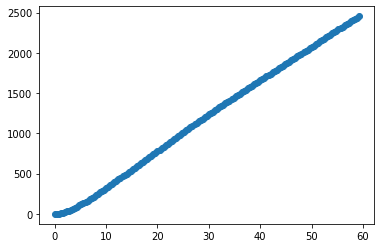

In [28]:
plt.scatter(dt_of_steps, all_means)

plt.show()

Время когда парабола переходит в прямую - это время свободного пробега. Самый простой вариант это понять - в логарифмических координатах. Когда у нас парабола - это s^2 = t^2, то есть это просто свободное движение частицы. Короче вот такая вот парабола это правильно

Сейчас задача - построить достаточно широко по координате delta_t перемещения, чтобы было видно нормально и прямую и параболу

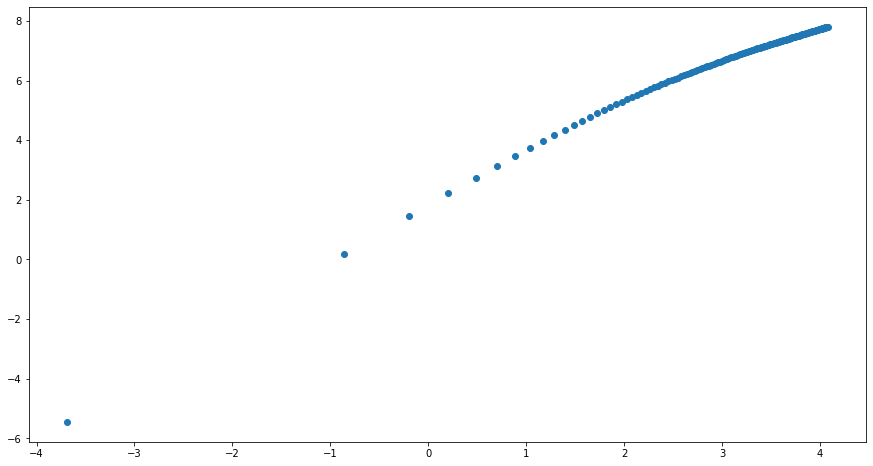

In [29]:
x = np.log(dt_of_steps)
y = np.log(all_means)
plt.figure(figsize=(15, 8))

plt.scatter(x, y)

plt.show()
